In [1]:
import torch
import pandas as pd
import os
import cv2
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
import sklearn
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from torchvision.transforms import v2
from PIL import Image
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image


device = torch.device(torch.accelerator.current_accelerator() if torch.accelerator.is_available() else 'cpu')
device

device(type='cuda')

# Mask Generator

In [2]:
import numpy as np

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    Converts RLE string to binary mask (numpy 2D array).
    '''
    if pd.isnull(mask_rle):
        return np.zeros(shape, dtype=np.uint8)

    s = list(map(int, mask_rle.split()))
    starts, lengths = s[::2], s[1::2]

    starts = np.array(starts) - 1  # switch to 0-based indexing
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)

    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1

    return img.reshape((shape[1], shape[0])).T  # reshape & transpose for (H, W)

def get_combined_mask(image_id, df, shape=(768, 768)):
    """
    Returns a binary mask for an image with possibly multiple ships.
    - image_id: name of the image (e.g., '00003e153.jpg')
    - df: the full DataFrame from the CSV
    - shape: expected shape of the output mask (default 768x768)
    """
    # Get all RLEs for the image
    rles = df[df["ImageId"] == image_id]["EncodedPixels"].dropna().values
    
    # Start with empty mask
    final_mask = np.zeros(shape, dtype=np.uint8)
    
    for rle in rles:
        final_mask += rle_decode(rle, shape=shape)
    
    # Make sure the mask is binary (in case ships overlap)
    final_mask = np.clip(final_mask, 0, 1)
    
    return final_mask

In [3]:
def show_image_with_mask(image_id, df, shape=(768, 768)):
    """
    Displays the image and its corresponding mask.
    - image_id: name of the image (e.g., '00003e153.jpg')
    - df: the full DataFrame from the CSV
    - shape: expected shape of the mask (default 768x768)
    """
    # Load the image
    img_path = os.path.join("./airbus-ship-detection/train_v2_resized", image_id)
    img = Image.open(img_path).convert("RGB")
    
    # Load the mask image (as .png)
    mask_path = os.path.join("./airbus-ship-detection/train_masks_resized", image_id.replace('.jpg', '.png'))
    mask = Image.open(mask_path)
    
    # Display the image and mask
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    
    plt.show()

In [4]:
mask_df = pd.read_csv("./airbus-ship-detection/train_ship_segmentations_v2.csv")
mask_df['HasShip'] = mask_df['EncodedPixels'].notnull().astype(int)

#count the number of times each image appears in the dataframe
ship_counts = mask_df.groupby('ImageId')['HasShip'].sum().reset_index()

#set ship count as a new column
ship_counts.rename(columns={'HasShip': 'ShipCount'}, inplace=True)
mask_df = mask_df.merge(ship_counts, on='ImageId', how='left')

mask_df

ImageId                                      EncodedPixels  \
0       00003e153.jpg                                                NaN   
1       0001124c7.jpg                                                NaN   
2       000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...   
3       000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...   
4       000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...   
...               ...                                                ...   
231718  fffedbb6b.jpg                                                NaN   
231719  ffff2aa57.jpg                                                NaN   
231720  ffff6e525.jpg                                                NaN   
231721  ffffc50b4.jpg                                                NaN   
231722  ffffe97f3.jpg                                                NaN   

        HasShip  ShipCount  
0             0          0  
1             0          0  
2             1          1  
3             1          5  
4             1          5  
...         ...        ...  
231718        0          0  
231719        0          0  
231720        0          0  
231721        0          0  
231722        0          0  

[231723 rows x 4 columns]

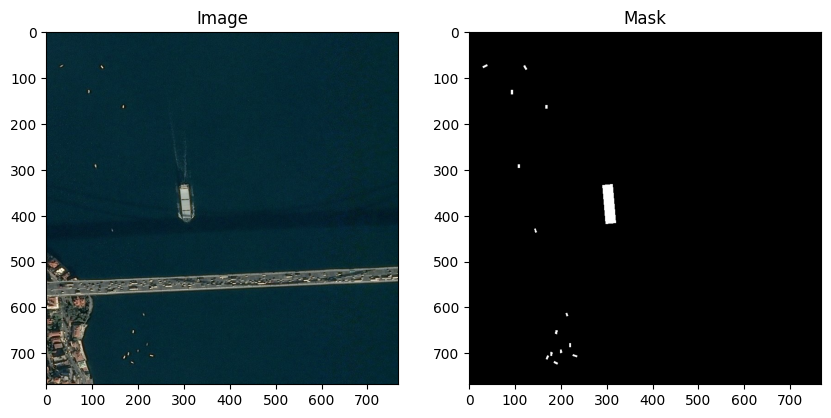

In [5]:
def show_image_with_mask(image_id, df, shape=(768, 768)):
    """
    Displays the image and its corresponding mask.
    - image_id: name of the image (e.g., '00003e153.jpg')
    - df: the full DataFrame from the CSV
    - shape: expected shape of the mask (default 768x768)
    """
    # Load the image
    img_path = os.path.join("./airbus-ship-detection/train_v2", image_id)
    img = Image.open(img_path).convert("RGB")
    
    # Load the mask image (as .png)
    mask_path = os.path.join("./airbus-ship-detection/train_masks", image_id.replace('.jpg', '.png'))
    mask = Image.open(mask_path)
    
    # Display the image and mask
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    
    plt.show()

# Example usage
show_image_with_mask('ad5092ca2.jpg', mask_df)

In [6]:
from torch.utils.data import Dataset
import torch
import numpy as np
from PIL import Image

class PatchSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, patch_size=256):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.patch_size = patch_size

    def __len__(self):
        return len(self.image_paths) * 9  # 3x3 patches per image

    def __getitem__(self, idx):
        img_idx = idx // 9
        patch_idx = idx % 9

        # Load full image and mask
        image = np.array(Image.open(self.image_paths[img_idx]).convert("RGB"))  # [H, W, 3]
        mask = np.array(Image.open(self.mask_paths[img_idx]).convert("L"))      # [H, W]

        # Patch coordinates
        y = (patch_idx // 3) * self.patch_size
        x = (patch_idx % 3) * self.patch_size

        # Extract patches
        image_patch = image[y:y+self.patch_size, x:x+self.patch_size, :]  # [H, W, 3]
        mask_patch = mask[y:y+self.patch_size, x:x+self.patch_size]       # [H, W]

        # Convert to torch tensors and scale to [0, 1]
        image_patch = torch.from_numpy(image_patch).permute(2, 0, 1).float() / 255.0  # [3, H, W]
        mask_patch = torch.from_numpy(mask_patch).unsqueeze(0).float() / 255.0        # [1, H, W]

        return image_patch, mask_patch


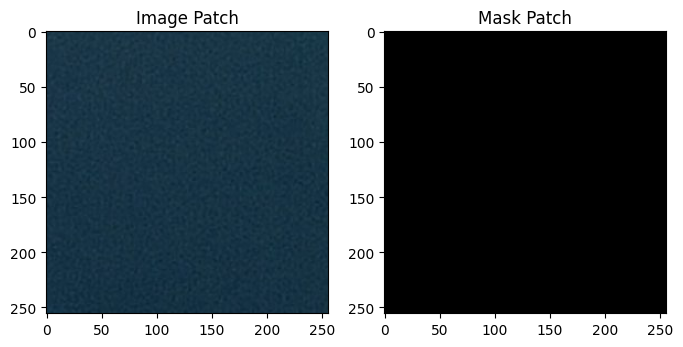

Found ship in patch index: 22


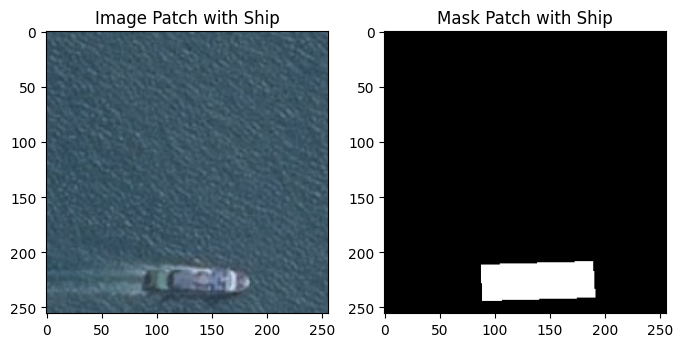

In [7]:
# Rebuild lists
image_paths = sorted([
    os.path.join("./airbus-ship-detection/train_v2", f)
    for f in os.listdir("./airbus-ship-detection/train_v2") if f.endswith(".jpg")
])
mask_paths = sorted([
    os.path.join("./airbus-ship-detection/train_masks", f.replace(".jpg", ".png"))
    for f in os.listdir("./airbus-ship-detection/train_v2") if f.endswith(".jpg")
])

# No augmentations or normalization
dataset = PatchSegmentationDataset(image_paths, mask_paths, patch_size=256)

# Visualize a sample
import matplotlib.pyplot as plt
img, mask = dataset[124]
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0).numpy())
plt.title("Image Patch")
plt.subplot(1, 2, 2)
plt.imshow(mask.squeeze(0).numpy(), cmap='gray')
plt.title("Mask Patch")
plt.show()


#find a patch with a ship
def find_patch_with_ship(dataset):
    for idx in range(len(dataset)):
        _, mask = dataset[idx]
        if mask.sum() > 0:  # Check if the mask has any ship pixels
            return idx, dataset[idx]
    return None, None

idx, (img, mask) = find_patch_with_ship(dataset)
if idx is not None:
    print(f"Found ship in patch index: {idx}")
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.title("Image Patch with Ship")
    plt.subplot(1, 2, 2)
    plt.imshow(mask.squeeze(0).numpy(), cmap='gray')
    plt.title("Mask Patch with Ship")
    plt.show()


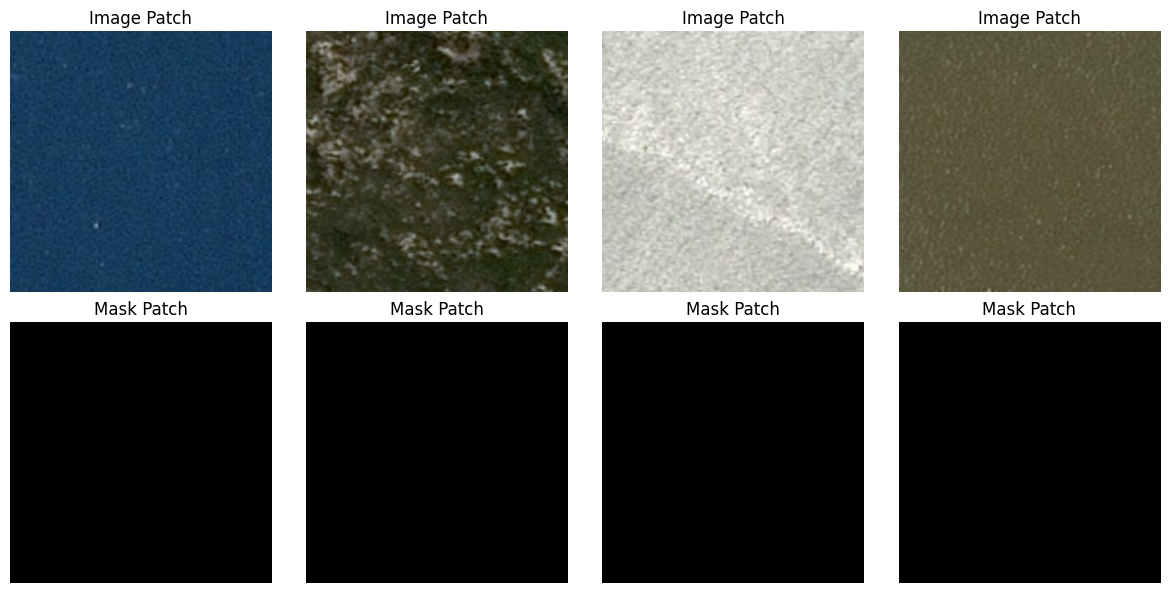

In [8]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

loader = DataLoader(dataset, batch_size=4, shuffle=True)
images, masks = next(iter(loader))

plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].permute(1, 2, 0).numpy())
    plt.title("Image Patch")
    plt.axis('off')

    plt.subplot(2, 4, i + 5)
    plt.imshow(masks[i].squeeze(0).numpy(), cmap='gray')
    plt.title("Mask Patch")
    plt.axis('off')
plt.tight_layout()
plt.show()


Total available: 78883 ship patches, 1654121 empty patches
Train dataset: 16000 ship patches, 4000 empty patches
Total available: 78883 ship patches, 1654121 empty patches
Val dataset: 1000 ship patches, 1000 empty patches
Total available: 78883 ship patches, 1654121 empty patches
Test dataset: 250 ship patches, 250 empty patches


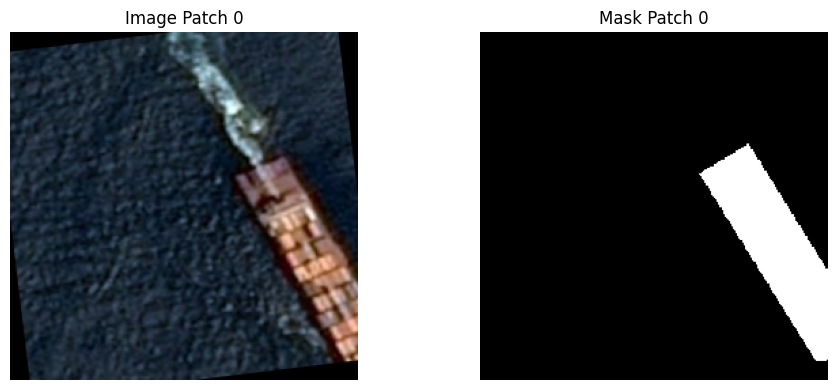

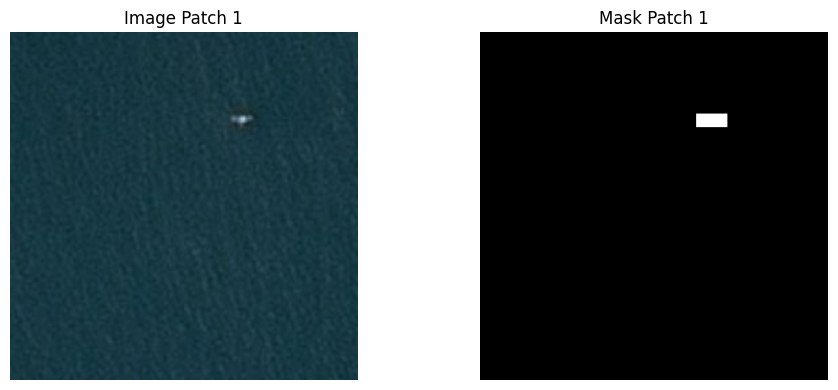

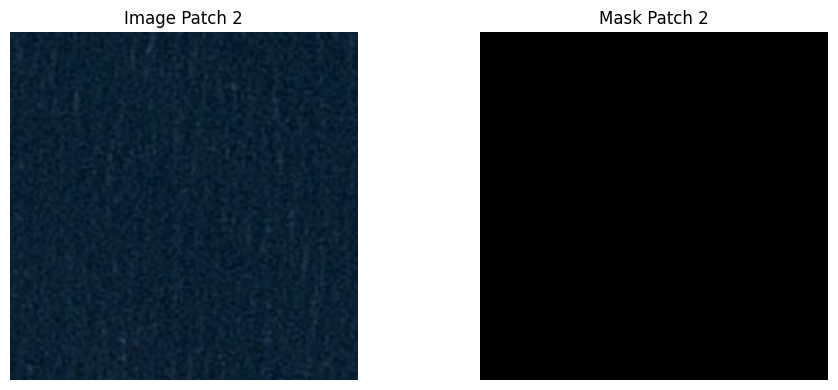

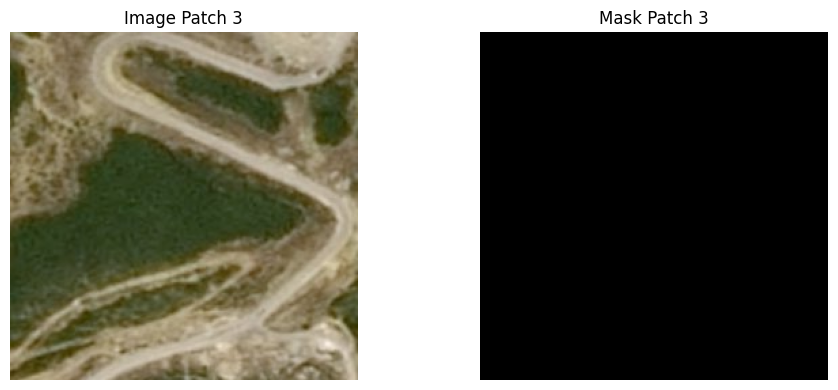

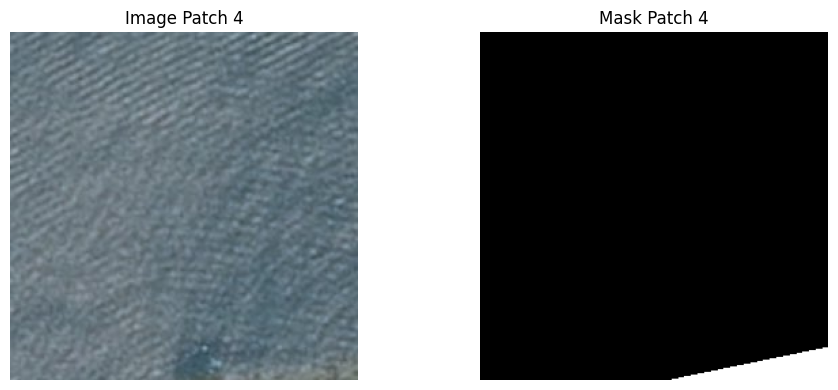

In [9]:
from torch.utils.data import Dataset
import torch
import numpy as np
from PIL import Image
from random import sample, shuffle
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

class OnlyShipPatchDataset(Dataset):
    def __init__(self, image_paths, mask_paths, patch_size=256, mode='train', train_samples=None, val_samples=None, test_samples = None, ship_ratio=0.5):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.patch_size = patch_size
        self.mode = mode
        self.patch_indices = []
        self.augment = self.get_augmentation(mode)

        ship_patches = []
        empty_patches = []

        # Collect all patches
        for img_idx, mask_path in enumerate(self.mask_paths):
            try:
                mask = np.array(Image.open(mask_path).convert("L"))
                for patch_idx in range(9):
                    y = (patch_idx // 3) * patch_size
                    x = (patch_idx % 3) * patch_size
                    patch = mask[y:y+patch_size, x:x+patch_size]

                    if patch.sum() > 0:
                        ship_patches.append((img_idx, patch_idx))
                    else:
                        empty_patches.append((img_idx, patch_idx))
            except Exception as e:
                print(f"Error processing mask {mask_path}: {e}")
                continue

        print(f"Total available: {len(ship_patches)} ship patches, {len(empty_patches)} empty patches")

        # Create dataset based on mode
        if mode == 'train':
            if train_samples:
                # Option 1: Fixed number of samples (for computational efficiency)
                # You can choose the ratio of ship vs empty patches
                num_ship = min(int(train_samples * 0.8), len(ship_patches))  # 80% ships
                num_empty = min(train_samples - num_ship, len(empty_patches))
                
                self.patch_indices = (sample(ship_patches, num_ship) + sample(empty_patches, num_empty))
                shuffle(self.patch_indices)
            else:
                # Option 2: Use all ship patches + equal number of empty patches
                # This maximizes ship data but might be computationally expensive
                num_empty = min(len(ship_patches), len(empty_patches))
                self.patch_indices = (ship_patches + sample(empty_patches, num_empty))
                shuffle(self.patch_indices)
                
        elif mode == 'val':
            if val_samples:
                # For validation: Use balanced dataset
                num_ship = min(int(val_samples * ship_ratio), len(ship_patches))
                num_empty = min(val_samples - num_ship, len(empty_patches))
                
                self.patch_indices = (sample(ship_patches, num_ship) + sample(empty_patches, num_empty))
                shuffle(self.patch_indices)
            else:
                # Use balanced validation set
                min_patches = min(len(ship_patches), len(empty_patches))
                self.patch_indices = (sample(ship_patches, min_patches) + sample(empty_patches, min_patches))
                shuffle(self.patch_indices)

        elif mode == 'test':
            # For test mode, we can use a fixed number of patches or all available patches
            if test_samples:
                num_samples = min(test_samples, len(ship_patches) + len(empty_patches))
                self.patch_indices = (sample(ship_patches, num_samples // 2) + sample(empty_patches, num_samples // 2))
                shuffle(self.patch_indices)
            else:
                # Use all available patches
                self.patch_indices = ship_patches + empty_patches
                shuffle(self.patch_indices)

        ship_count = sum(1 for img_idx, patch_idx in self.patch_indices if self._has_ship(img_idx, patch_idx))
        empty_count = len(self.patch_indices) - ship_count
        
        print(f"{mode.capitalize()} dataset: {ship_count} ship patches, {empty_count} empty patches")

    def _has_ship(self, img_idx, patch_idx):
        """Check if a patch has ship pixels"""
        try:
            mask = np.array(Image.open(self.mask_paths[img_idx]).convert("L"))
            y = (patch_idx // 3) * self.patch_size
            x = (patch_idx % 3) * self.patch_size
            patch = mask[y:y+self.patch_size, x:x+self.patch_size]
            return patch.sum() > 0
        except:
            return False

    def get_augmentation(self, mode):
        if mode == 'train':
            return A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
                A.Rotate(limit=15, border_mode=0, p=0.3),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])
        else:
            return A.Compose([
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])

    def __len__(self):
        return len(self.patch_indices)

    def __getitem__(self, idx):
        img_idx, patch_idx = self.patch_indices[idx]
        
        try:
            # Load image and mask
            image = np.array(Image.open(self.image_paths[img_idx]).convert("RGB"))
            mask = np.array(Image.open(self.mask_paths[img_idx]).convert("L"))

            # Extract patches
            y = (patch_idx // 3) * self.patch_size
            x = (patch_idx % 3) * self.patch_size

            image_patch = image[y:y+self.patch_size, x:x+self.patch_size, :]
            mask_patch = mask[y:y+self.patch_size, x:x+self.patch_size]

            # Ensure mask is binary (0 or 1)
            mask_patch = (mask_patch > 0).astype(np.uint8)

            # Apply augmentation
            augmented = self.augment(image=image_patch, mask=mask_patch)
            image_patch = augmented['image']
            mask_patch = augmented['mask']

            # Ensure mask is float and add channel dimension if needed
            if mask_patch.dim() == 2:
                mask_patch = mask_patch.unsqueeze(0)
            mask_patch = mask_patch.float()

            return image_patch, mask_patch
            
        except Exception as e:
            print(f"Error loading patch {idx}: {e}")
            return torch.zeros(3, self.patch_size, self.patch_size), torch.zeros(1, self.patch_size, self.patch_size)


# Usage examples:

# Option 1: Fixed sample size for computational efficiency
train_dataset = OnlyShipPatchDataset(
    image_paths, mask_paths, 
    patch_size=256, 
    mode='train', 
    train_samples=20000  # 16k ship + 4k empty (80/20 split)
)

# Validation dataset (always balanced for fair evaluation)
val_dataset = OnlyShipPatchDataset(
    image_paths, mask_paths, 
    patch_size=256, 
    mode='val', 
    val_samples=2000,  # 1k ship + 1k empty (balanced)
    ship_ratio=0.5
)

# create a test dataset of 500 images
test_dataset = OnlyShipPatchDataset(
    image_paths, mask_paths, 
    patch_size=256,
    mode='test',  # Test mode, no augmentation
    test_samples=500, 
    ship_ratio=0.5  # Use same ratio as validation
)

# Fixed visualization function
def visualize_samples(dataset, num_samples=5):
    """Visualize samples from the dataset with proper denormalization"""
    
    # ImageNet normalization values
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    for i in range(min(num_samples, len(dataset))):
        img, mask = dataset[i]
        
        # Denormalize image for visualization
        img_np = img.permute(1, 2, 0).numpy()
        img_np = img_np * std + mean
        img_np = np.clip(img_np, 0, 1)
        
        # Convert mask to numpy
        mask_np = mask.squeeze(0).numpy()
        
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img_np)
        plt.title(f"Image Patch {i}")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(mask_np, cmap='gray')
        plt.title(f"Mask Patch {i}")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

# Visualize samples
visualize_samples(train_dataset, 5)

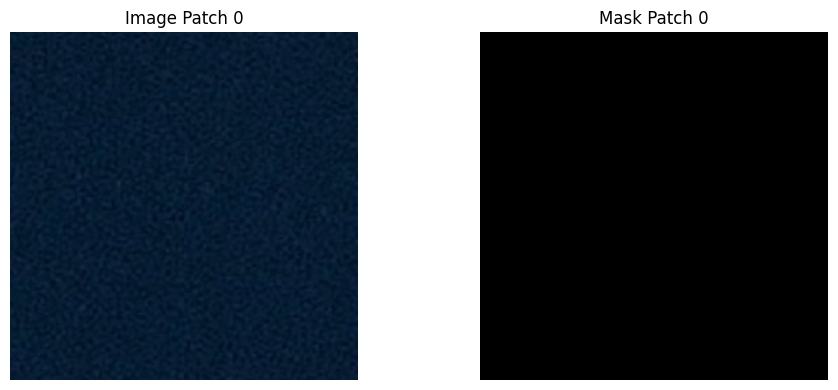

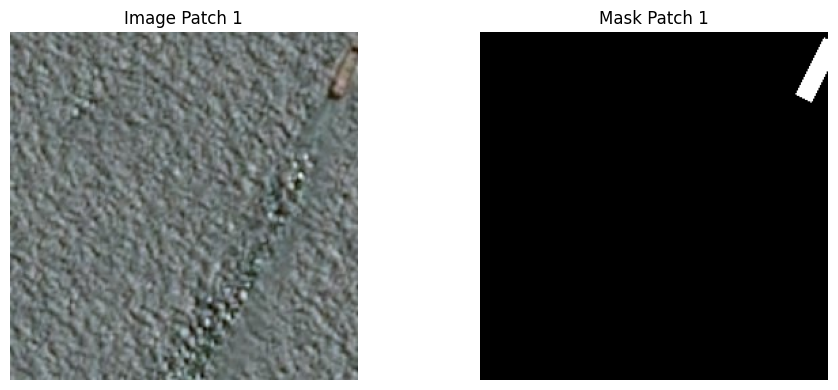

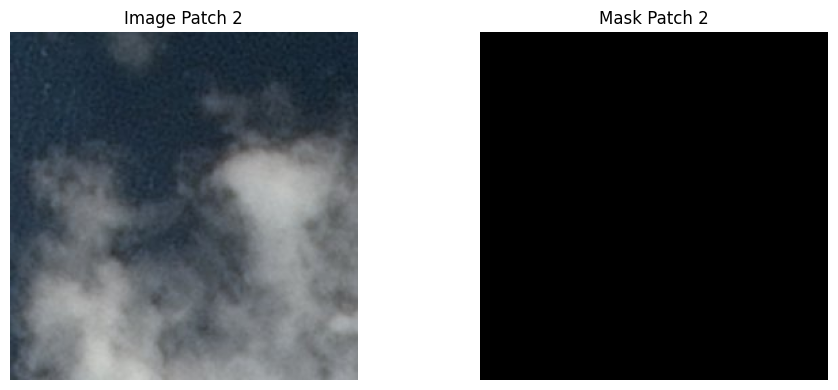

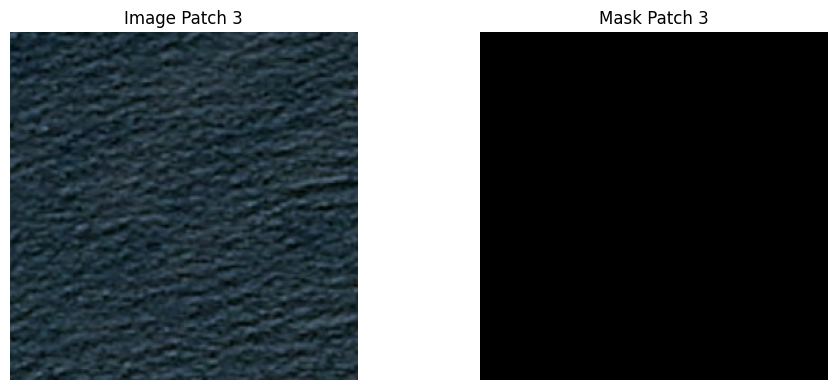

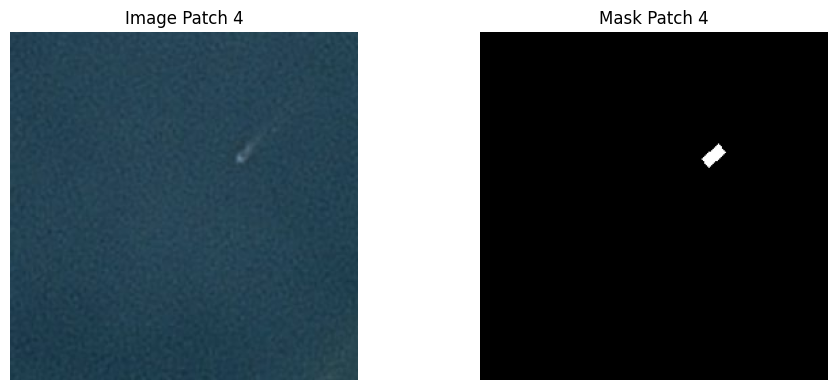

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1659663].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.2565577].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5014129..1.9033612].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


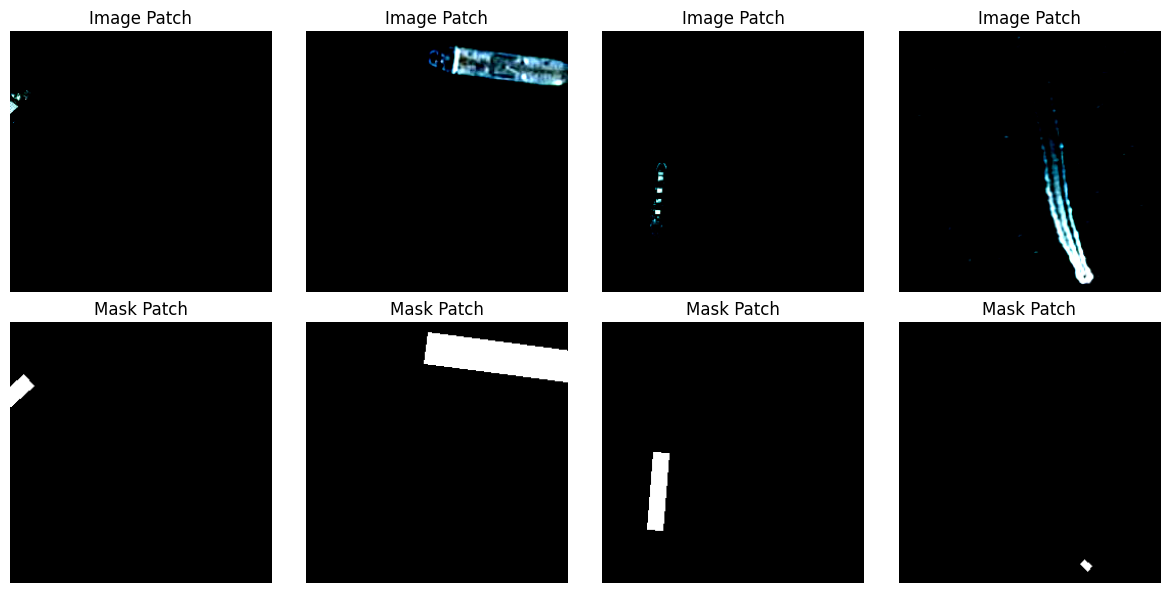

In [17]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

visualize_samples(val_dataset, 5)

# Visualize a batch of patches
for images, masks in train_dataloader:
    plt.figure(figsize=(12, 6))
    for i in range(4):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).numpy())
        plt.title("Image Patch")
        plt.axis('off')

        plt.subplot(2, 4, i + 5)
        plt.imshow(masks[i].squeeze(0).numpy(), cmap='gray')
        plt.title("Mask Patch")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    break

In [18]:
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

class BetterSegNet1(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc1 = ConvBlock(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = ConvBlock(256, 512)

        # Decoder
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = ConvBlock(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = ConvBlock(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = ConvBlock(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool1(x1))
        x3 = self.enc3(self.pool2(x2))
        x4 = self.bottleneck(self.pool3(x3))

        x = self.up3(x4)
        x = self.dec3(torch.cat([x, x3], dim=1))
        x = self.up2(x)
        x = self.dec2(torch.cat([x, x2], dim=1))
        x = self.up1(x)
        x = self.dec1(torch.cat([x, x1], dim=1))

        return self.final(x)  # raw logits
    


In [19]:
import torch
import torch.nn as nn

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1),
            nn.SiLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        w = self.pool(x)
        w = self.fc(w)
        return x * w

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, use_se=True, residual=True, dropout=0.0):
        super().__init__()
        self.residual = residual and in_ch == out_ch
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, in_ch, 3, padding=1, groups=in_ch),  # depthwise
            nn.Conv2d(in_ch, out_ch, 1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU(inplace=True),

            nn.Conv2d(out_ch, out_ch, 3, padding=1, groups=out_ch),
            nn.Conv2d(out_ch, out_ch, 1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU(inplace=True),
            nn.Dropout2d(dropout) if dropout > 0 else nn.Identity()
        )
        self.se = SEBlock(out_ch) if use_se else nn.Identity()

    def forward(self, x):
        out = self.conv(x)
        out = self.se(out)
        if self.residual:
            return out + x
        return out

class BetterSegNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = ConvBlock(3, 64, dropout=0.1)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(64, 128, dropout=0.1)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256, dropout=0.2)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ConvBlock(256, 512, dropout=0.3)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = ConvBlock(512, 1024, dropout=0.4)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = ConvBlock(1024, 512, dropout=0.3)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = ConvBlock(512, 256, dropout=0.2)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = ConvBlock(256, 128, dropout=0.1)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = ConvBlock(128, 64, dropout=0.1)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x1 = self.enc1(x)       # 64
        x2 = self.enc2(self.pool1(x1))   # 128
        x3 = self.enc3(self.pool2(x2))   # 256
        x4 = self.enc4(self.pool3(x3))   # 512
        x5 = self.bottleneck(self.pool4(x4))  # 1024

        x = self.up4(x5)
        x = self.dec4(torch.cat([x, x4], dim=1))
        x = self.up3(x)
        x = self.dec3(torch.cat([x, x3], dim=1))
        x = self.up2(x)
        x = self.dec2(torch.cat([x, x2], dim=1))
        x = self.up1(x)
        x = self.dec1(torch.cat([x, x1], dim=1))

        return self.final(x)  # logits
    

model = BetterSegNet2().to(device)


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1),
            nn.SiLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        w = self.pool(x)
        w = self.fc(w)
        return x * w

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, use_se=True, residual=True, dropout=0.0):
        super().__init__()
        self.residual = residual and in_ch == out_ch
        
        # Main improvement: better conv structure
        self.conv = nn.Sequential(
            # First conv - regular 3x3
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),  # Changed from GroupNorm to BatchNorm
            nn.SiLU(inplace=True),   # Using SiLU (Swish) activation
            
            # Second conv - dilated for better receptive field
            nn.Conv2d(out_ch, out_ch, 3, padding=2, dilation=2, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.SiLU(inplace=True),
            nn.Dropout2d(dropout) if dropout > 0 else nn.Identity()
        )
        
        # Projection layer for residual connection when channels differ
        self.proj = nn.Conv2d(in_ch, out_ch, 1, bias=False) if in_ch != out_ch else nn.Identity()
        
        self.se = SEBlock(out_ch) if use_se else nn.Identity()

    def forward(self, x):
        identity = self.proj(x) if self.residual else None
        
        out = self.conv(x)
        out = self.se(out)
        
        if self.residual and identity is not None:
            out = out + identity
            
        return out

class ImprovedSegNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder - same structure as yours
        self.enc1 = ConvBlock(3, 64, dropout=0.1)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(64, 128, dropout=0.1)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256, dropout=0.2)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ConvBlock(256, 512, dropout=0.3)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck with simple multi-scale features
        self.bottleneck = nn.Sequential(
            ConvBlock(512, 1024, dropout=0.4),
            # Add one more conv for better feature extraction
            nn.Conv2d(1024, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )

        # Decoder - same structure as yours
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = ConvBlock(1024, 512, dropout=0.3)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = ConvBlock(512, 256, dropout=0.2)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = ConvBlock(256, 128, dropout=0.1)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = ConvBlock(128, 64, dropout=0.1)

        # Improved final layer
        self.final = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(inplace=True),
            nn.Conv2d(32, 1, 1)
        )
        
        # Initialize weights properly
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')  # Keep relu for init
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)       # 64
        x2 = self.enc2(self.pool1(x1))   # 128
        x3 = self.enc3(self.pool2(x2))   # 256
        x4 = self.enc4(self.pool3(x3))   # 512
        x5 = self.bottleneck(self.pool4(x4))  # 1024

        # Decoder
        x = self.up4(x5)
        x = self.dec4(torch.cat([x, x4], dim=1))
        x = self.up3(x)
        x = self.dec3(torch.cat([x, x3], dim=1))
        x = self.up2(x)
        x = self.dec2(torch.cat([x, x2], dim=1))
        x = self.up1(x)
        x = self.dec1(torch.cat([x, x1], dim=1))

        return self.final(x)

In [21]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

# Improved loss functions
bce = nn.BCEWithLogitsLoss()

def dice_loss(pred, target, smooth=1):
    """
    Improved dice loss implementation
    """
    pred = torch.sigmoid(pred)
    pred = pred.view(-1)
    target = target.view(-1)
    
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

def dice_coefficient(pred, target, smooth=1):
    """
    Calculate dice coefficient for evaluation
    """
    pred = pred.view(-1)
    target = target.view(-1)
    
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def combined_loss(pred, target):
    """
    Combined loss with proper weighting
    """
    bce_loss = bce(pred, target)
    dice_loss_val = dice_loss(pred, target)
    
    # You can adjust these weights based on your needs
    return 0.5 * bce_loss + 0.5 * dice_loss_val

In [22]:
def mask_to_box_mask(pred):
    """
    Converts a batch of binary segmentation masks into masks with filled bounding boxes.
    Input: pred (B, 1, H, W), binary mask
    Output: box_mask (B, 1, H, W), binary mask with bounding boxes
    """
    # Handle single prediction case
    if pred.dim() == 3:
        pred = pred.unsqueeze(0)
    
    pred_np = pred.squeeze(1).cpu().numpy()
    box_masks = []

    for mask in pred_np:
        mask = (mask * 255).astype(np.uint8)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        box_mask = np.zeros_like(mask)

        for contour in contours:
            if cv2.contourArea(contour) < 100:
                continue
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(box_mask, (x, y), (x + w, y + h), 255, thickness=-1)

        box_masks.append(box_mask)

    box_masks = torch.tensor(np.array(box_masks), dtype=torch.float32).unsqueeze(1).to(pred.device) / 255.0
    return box_masks



Epoch 1/30


Validation: 100%|██████████| 250/250 [00:52<00:00,  4.81it/s]


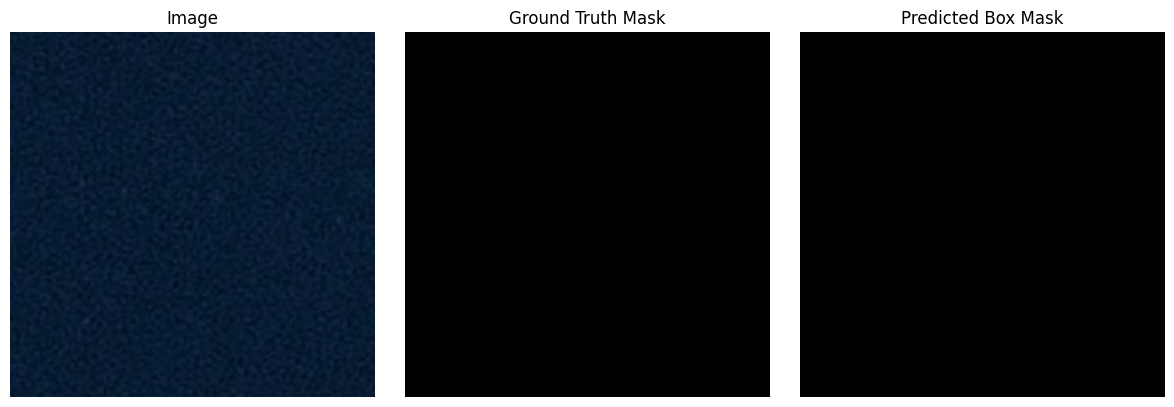

Train Loss: 0.2523, Dice: 0.4710
Val   Loss: 0.2135, Dice: 0.5047

Epoch 2/30


Validation: 100%|██████████| 250/250 [00:35<00:00,  7.04it/s]


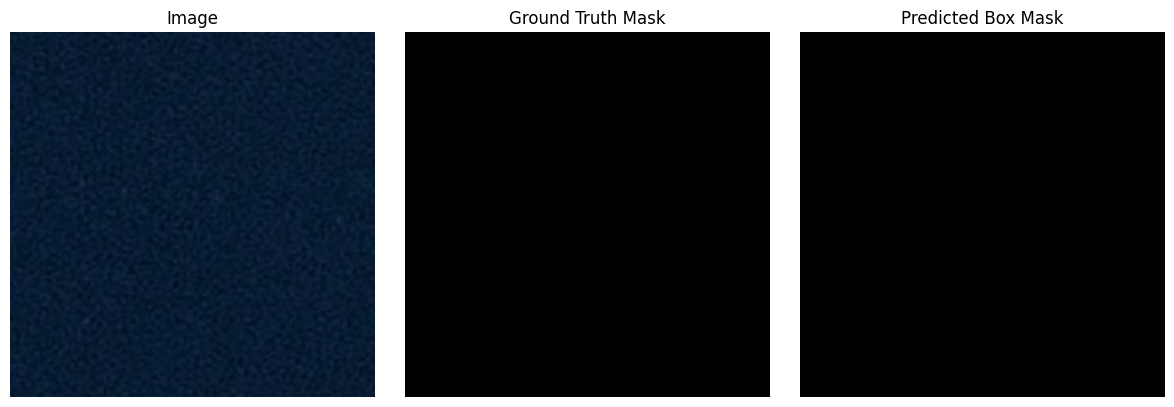

Train Loss: 0.2018, Dice: 0.5200
Val   Loss: 0.2204, Dice: 0.4851

Epoch 3/30


Validation: 100%|██████████| 250/250 [00:34<00:00,  7.28it/s]


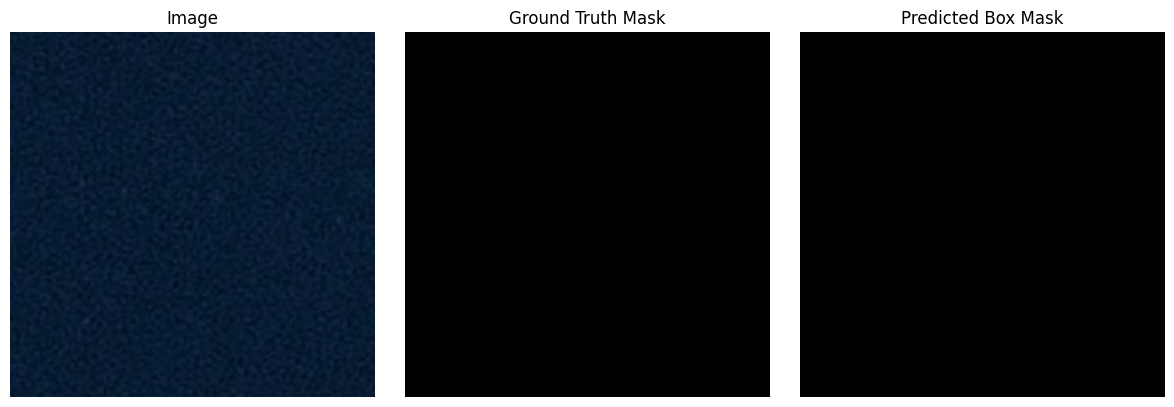

Train Loss: 0.1864, Dice: 0.5371
Val   Loss: 0.1829, Dice: 0.5212

Epoch 4/30


Validation: 100%|██████████| 250/250 [00:37<00:00,  6.75it/s]


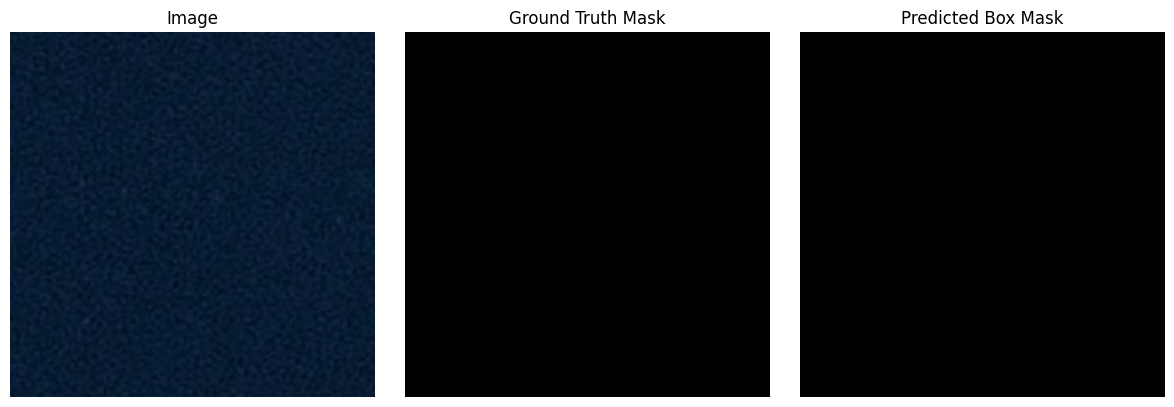

Train Loss: 0.1751, Dice: 0.5477
Val   Loss: 0.2099, Dice: 0.4914

Epoch 5/30


Validation: 100%|██████████| 250/250 [00:33<00:00,  7.46it/s]


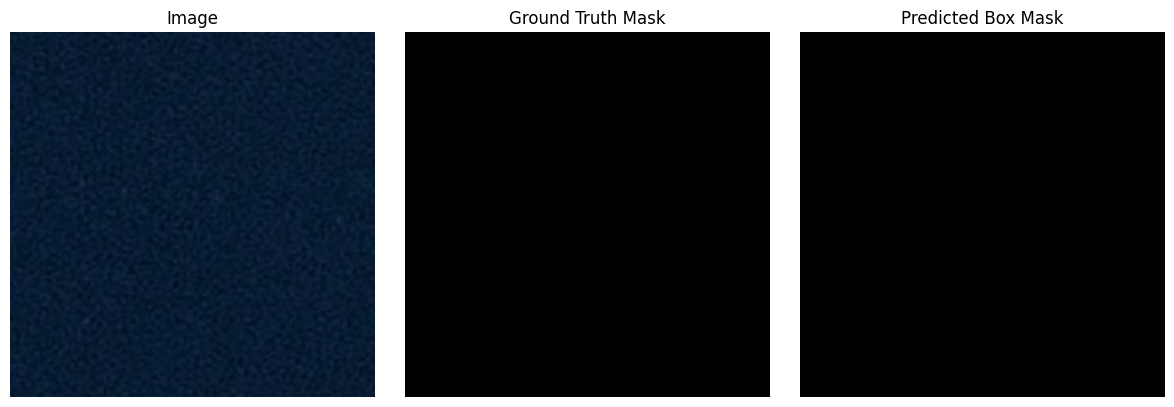

Train Loss: 0.1692, Dice: 0.5546
Val   Loss: 0.1730, Dice: 0.5520

Epoch 6/30


Validation: 100%|██████████| 250/250 [01:00<00:00,  4.16it/s]


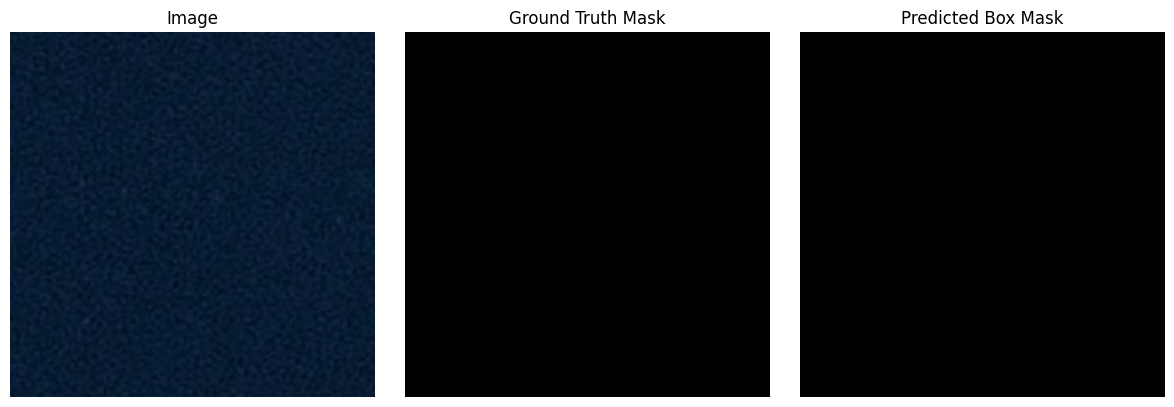

Train Loss: 0.1613, Dice: 0.5631
Val   Loss: 0.1716, Dice: 0.5467

Epoch 7/30


Validation: 100%|██████████| 250/250 [01:04<00:00,  3.88it/s]


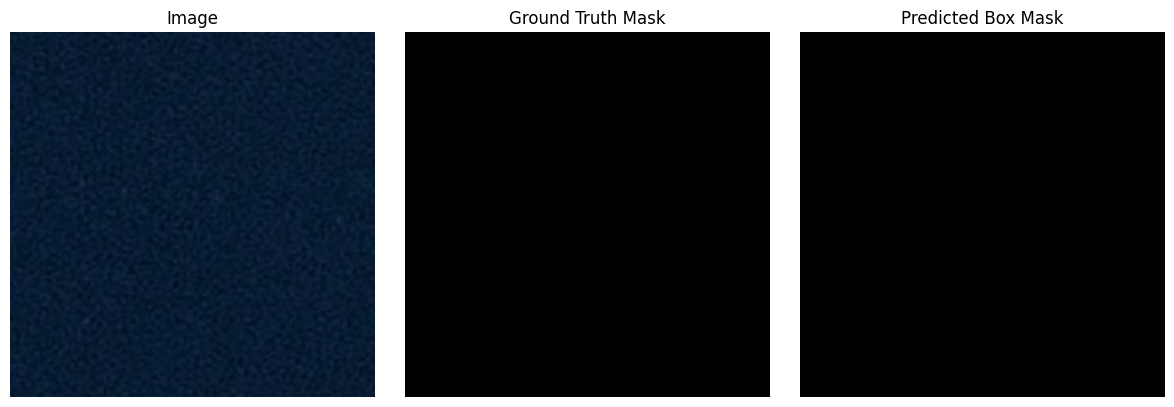

Train Loss: 0.1564, Dice: 0.5665
Val   Loss: 0.1612, Dice: 0.5369

Epoch 8/30


Validation: 100%|██████████| 250/250 [01:01<00:00,  4.04it/s]


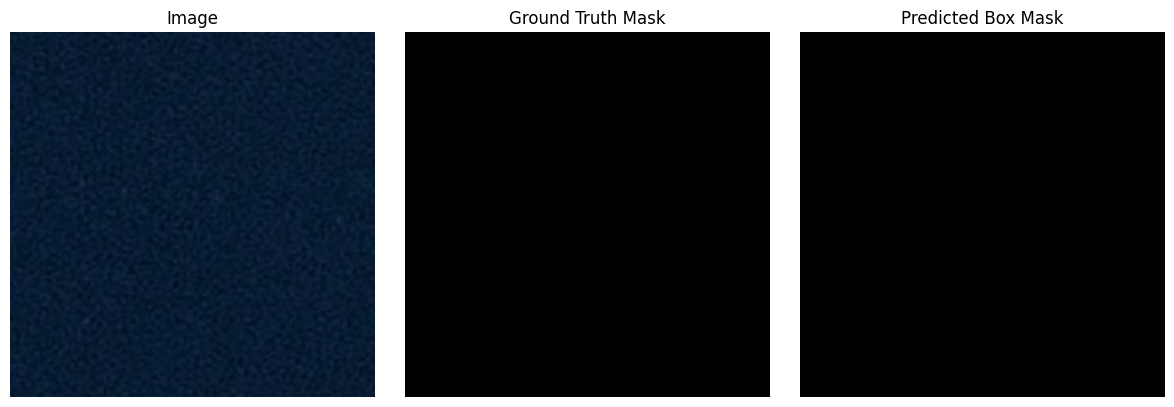

Train Loss: 0.1539, Dice: 0.5705
Val   Loss: 0.1609, Dice: 0.5450

Epoch 9/30


Validation: 100%|██████████| 250/250 [00:46<00:00,  5.41it/s]


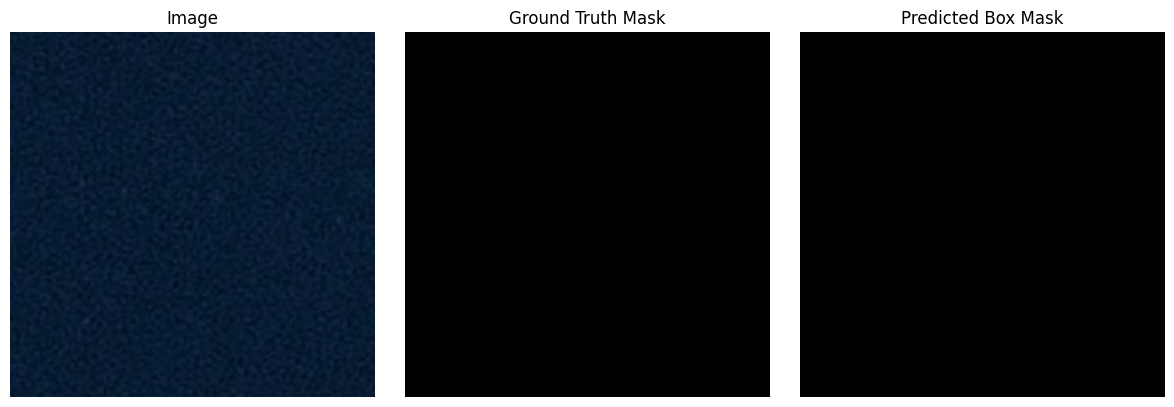

Train Loss: 0.1467, Dice: 0.5777
Val   Loss: 0.1586, Dice: 0.5664

Epoch 10/30


Validation: 100%|██████████| 250/250 [01:13<00:00,  3.38it/s]


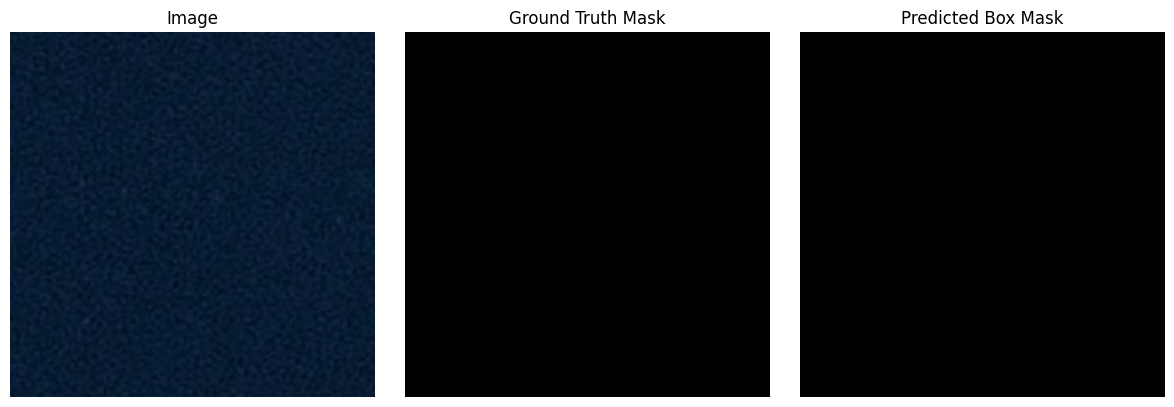

Train Loss: 0.1488, Dice: 0.5755
Val   Loss: 0.1481, Dice: 0.5761

Epoch 11/30


Validation: 100%|██████████| 250/250 [00:41<00:00,  6.08it/s]


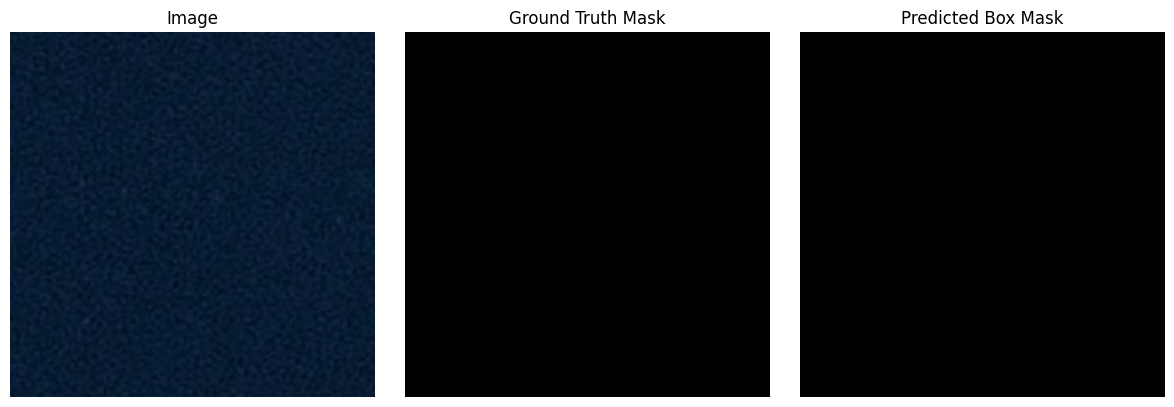

Train Loss: 0.1439, Dice: 0.5784
Val   Loss: 0.1510, Dice: 0.5701

Epoch 12/30


Validation: 100%|██████████| 250/250 [00:49<00:00,  5.01it/s]


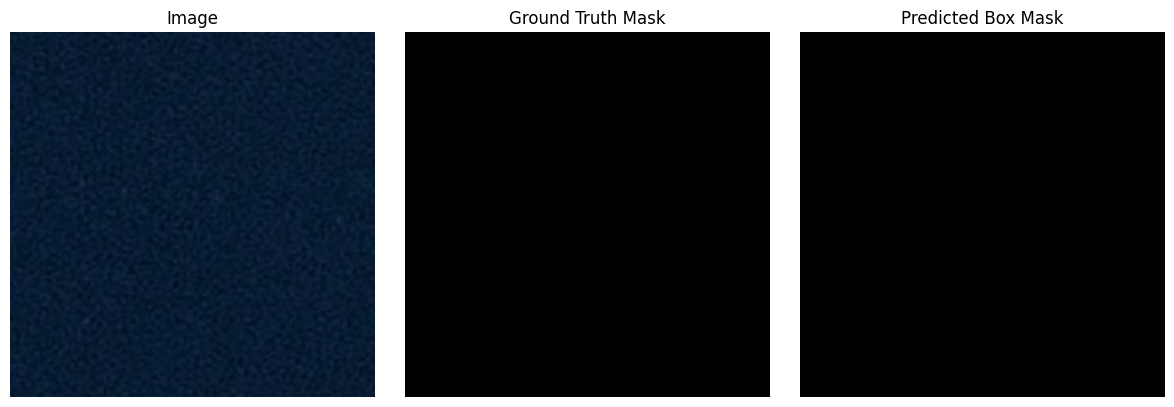

Train Loss: 0.1427, Dice: 0.5818
Val   Loss: 0.1488, Dice: 0.5699

Epoch 13/30


Validation: 100%|██████████| 250/250 [00:41<00:00,  6.08it/s]


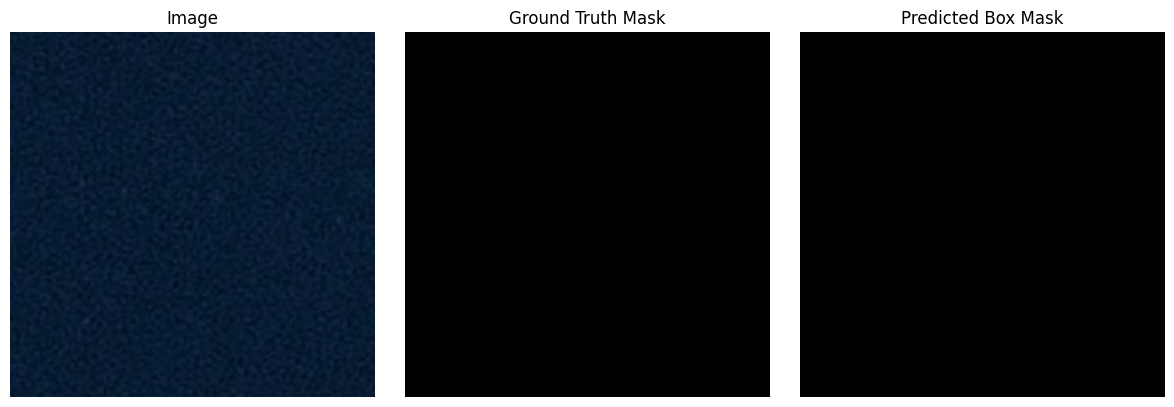

Train Loss: 0.1386, Dice: 0.5849
Val   Loss: 0.1433, Dice: 0.5758

Epoch 14/30


Validation: 100%|██████████| 250/250 [00:39<00:00,  6.33it/s]


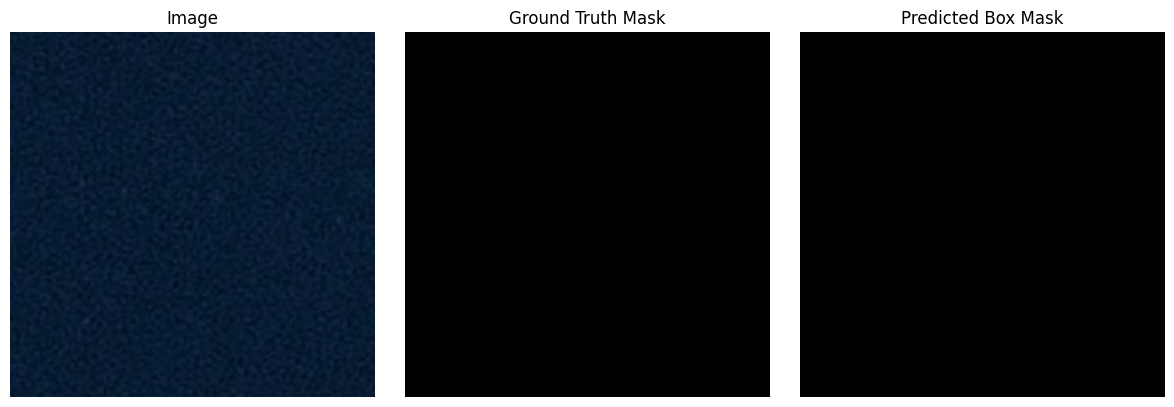

Train Loss: 0.1370, Dice: 0.5843
Val   Loss: 0.1426, Dice: 0.5761

Epoch 15/30


Validation: 100%|██████████| 250/250 [00:41<00:00,  6.09it/s]


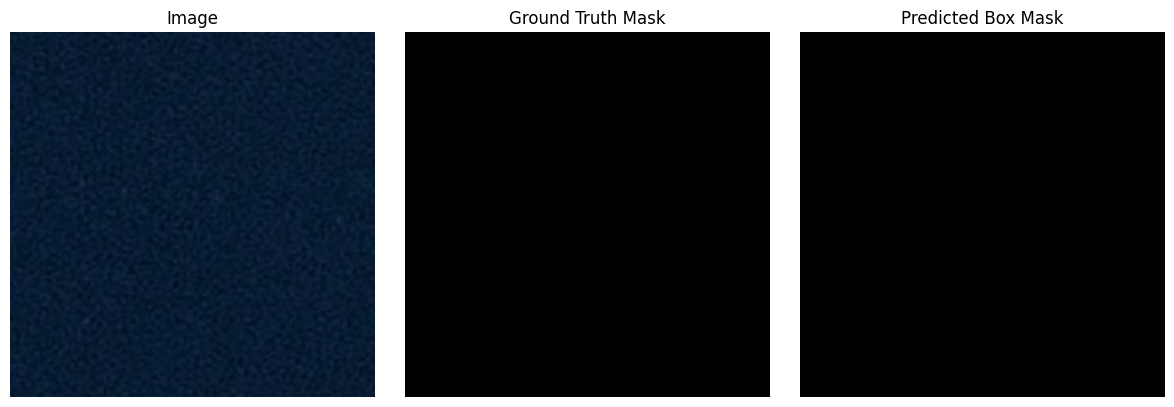

Train Loss: 0.1271, Dice: 0.5964
Val   Loss: 0.1333, Dice: 0.5763

Epoch 16/30


Validation: 100%|██████████| 250/250 [00:40<00:00,  6.13it/s]


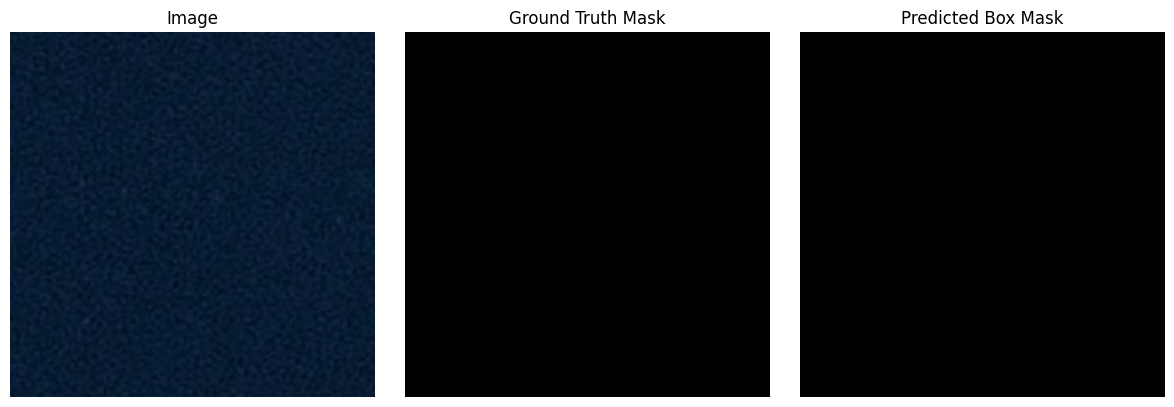

Train Loss: 0.1248, Dice: 0.5981
Val   Loss: 0.1304, Dice: 0.5815

Epoch 17/30


Validation: 100%|██████████| 250/250 [00:40<00:00,  6.16it/s]


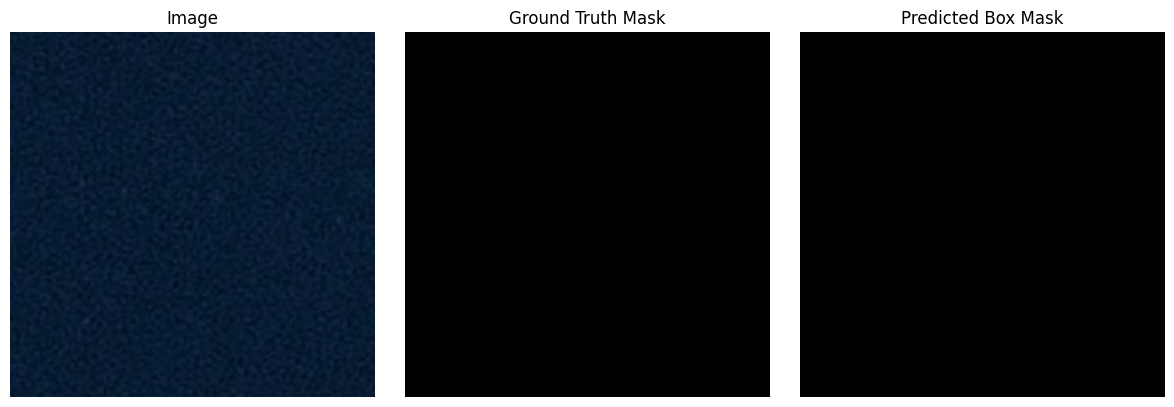

Train Loss: 0.1245, Dice: 0.5979
Val   Loss: 0.1303, Dice: 0.5882

Epoch 18/30


Validation: 100%|██████████| 250/250 [00:42<00:00,  5.94it/s]


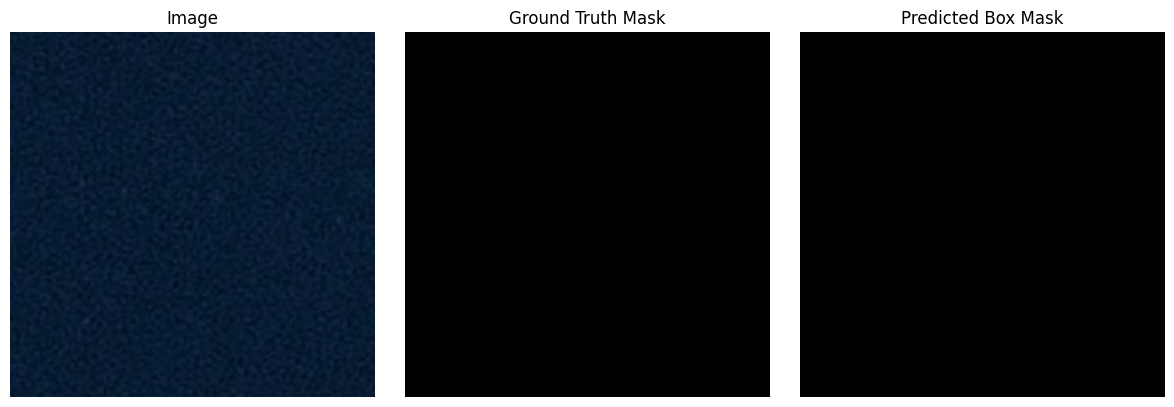

Train Loss: 0.1219, Dice: 0.6018
Val   Loss: 0.1269, Dice: 0.5948

Epoch 19/30


Validation: 100%|██████████| 250/250 [00:51<00:00,  4.81it/s]


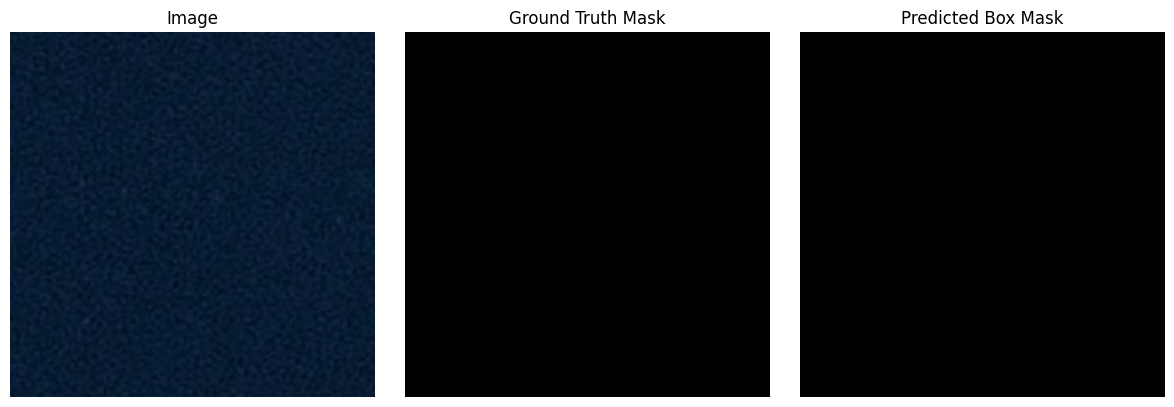

Train Loss: 0.1220, Dice: 0.5997
Val   Loss: 0.1244, Dice: 0.5890


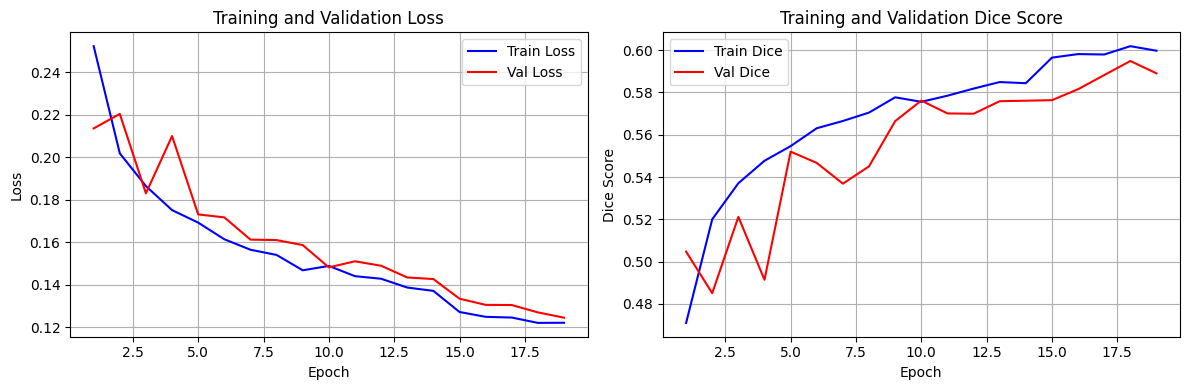

In [23]:
import torch
import torch.nn as nn
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',          # because we want to maximize validation Dice
    factor=0.5,          # reduce LR by half
    patience=3,          # wait 3 epochs before reducing
)

# Lists to store metrics for plotting
train_losses = []
val_losses = []
train_dices = []
val_dices = []

def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss, total_dice = 0, 0

    for images, masks in tqdm(loader, desc="Training"):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # Use the combined loss
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            pred = torch.sigmoid(outputs) > 0.5
            pred = pred.float()
            
            # Convert predictions to bounding boxes and calculate dice with GT boxes
            box_pred = mask_to_box_mask(pred)
            dice = dice_coefficient(box_pred, masks)

        total_loss += loss.item()
        total_dice += dice.item()

    return total_loss / len(loader), total_dice / len(loader)

def validate(model, loader, device):
    model.eval()
    total_loss, total_dice = 0, 0

    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validation"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            loss = combined_loss(outputs, masks)
            pred = torch.sigmoid(outputs) > 0.5
            pred = pred.float()
            
            # Convert predictions to bounding boxes and calculate dice with GT boxes
            box_pred = mask_to_box_mask(pred)
            dice = dice_coefficient(box_pred, masks)

            total_loss += loss.item()
            total_dice += dice.item()

    return total_loss / len(loader), total_dice / len(loader)

# Training loop
for epoch in range(1, 20):
    print(f"\nEpoch {epoch}/30")
    
    train_loss, train_dice = train_one_epoch(model, train_dataloader, optimizer, device)
    val_loss, val_dice = validate(model, val_dataloader, device)
    
    # Store metrics for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_dices.append(train_dice)
    val_dices.append(val_dice)

    # Adjust learning rate based on validation Dice
    scheduler.step(val_dice)
    
    # Fixed visualization
    plt.figure(figsize=(12, 4))
    img, mask = val_dataset[0]
    
    # Prepare image for model input
    img_input = img.unsqueeze(0).to(device)
    
    with torch.no_grad():
        pred_logits = model(img_input)
        pred_prob = torch.sigmoid(pred_logits)
        pred_binary = (pred_prob > 0.5).float()
        
        # Convert to bounding box mask
        box_pred = mask_to_box_mask(pred_binary)
    
    # Convert for visualization - denormalize the image
    img_vis = img.permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_vis = img_vis * std + mean
    img_vis = np.clip(img_vis, 0, 1)
    
    mask_vis = mask.squeeze(0).cpu().numpy()
    box_pred_vis = box_pred.squeeze(0).squeeze(0).cpu().numpy()
    
    plt.subplot(1, 3, 1)
    plt.imshow(img_vis)
    plt.title("Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask_vis, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(box_pred_vis, cmap='gray')
    plt.title("Predicted Box Mask")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

    print(f"Train Loss: {train_loss:.4f}, Dice: {train_dice:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Dice: {val_dice:.4f}")

# Plot learning curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_dices) + 1), train_dices, 'b-', label='Train Dice')
plt.plot(range(1, len(val_dices) + 1), val_dices, 'r-', label='Val Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.title('Training and Validation Dice Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [24]:
torch.save(model.state_dict(), "best_model_net_improve.pth")

# save the metrics to a CSV file
import pandas as pd
metrics_df = pd.DataFrame({
    'Epoch': range(1, len(train_losses) + 1),
    'Train Loss': train_losses,
    'Val Loss': val_losses,
    'Train Dice': train_dices,
    'Val Dice': val_dices
})
metrics_df.to_csv("training_metrics_improve.csv", index=False)

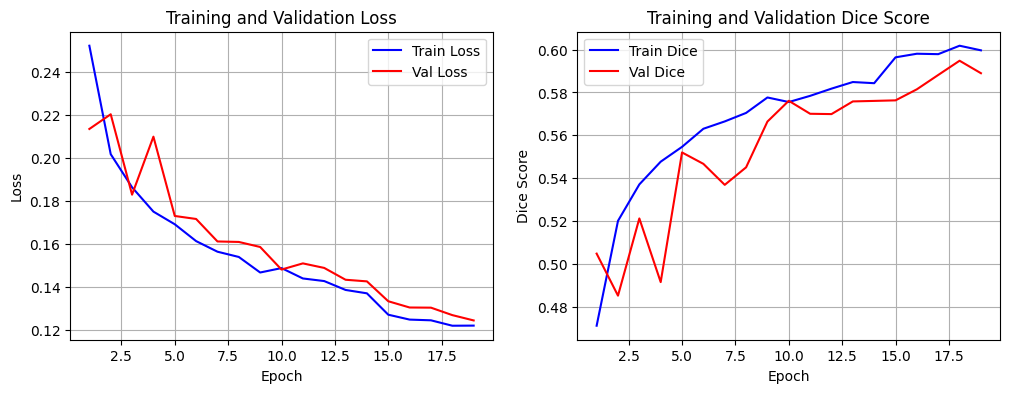

In [25]:
# learning curve traning and validation loss and dice score
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_dices) + 1), train_dices, 'b-', label='Train Dice')
plt.plot(range(1, len(val_dices) + 1), val_dices, 'r-', label='Val Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.title('Training and Validation Dice Score')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import jaccard_score, f1_score, accuracy_score, precision_score, recall_score

def evaluate_segmentation_model(model, dataloader, device='cuda'):
    model.eval()
    model.to(device)

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5  # binary mask
            preds = preds.long().cpu().numpy().reshape(-1)
            masks = masks.long().cpu().numpy().reshape(-1)

            all_preds.extend(preds)
            all_targets.extend(masks)

    # Compute metrics
    iou = jaccard_score(all_targets, all_preds, zero_division=0)
    dice = f1_score(all_targets, all_preds, zero_division=0)
    pixel_acc = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)

    print("\n📊 External Test Metrics:")
    print(f"IoU (Jaccard):     {iou:.4f}")
    print(f"Dice Coefficient:  {dice:.4f}")
    print(f"Pixel Accuracy:    {pixel_acc:.4f}")
    print(f"Precision:         {precision:.4f}")
    print(f"Recall:            {recall:.4f}")

    return {
        'iou': iou,
        'dice': dice,
        'pixel_acc': pixel_acc,
        'precision': precision,
        'recall': recall
    }

# Evaluate the model on the test dataset
test_metrics = evaluate_segmentation_model(model, test_dataloader, device=device)
# Save the test metrics to a CSV file
test_metrics_df = pd.DataFrame([test_metrics])
test_metrics_df.to_csv("test_metrics.csv", index=False)
print("Test metrics saved to 'test_metrics.csv'.")


📊 External Test Metrics:
IoU (Jaccard):     0.4376
Dice Coefficient:  0.6088
Pixel Accuracy:    0.9857
Precision:         0.4630
Recall:            0.8886
Test metrics saved to 'test_metrics.csv'.


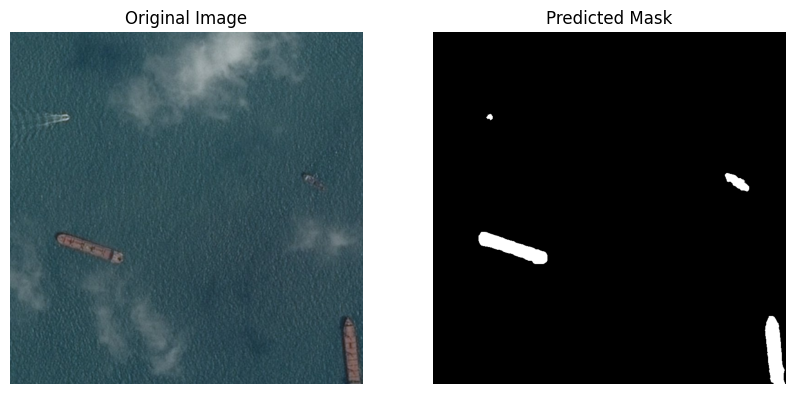

In [ ]:
from torchvision import transforms
from PIL import Image
import numpy as np
import torch

# Normalization transform (ImageNet-style)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

def segment_full_image(image_path, model, patch_size=256):
    """
    Segments the full image using the trained model.
    """
    image = np.array(Image.open(image_path).convert("RGB"))
    h, w, _ = image.shape

    # Prepare the output mask
    mask = np.zeros((h, w), dtype=np.float32)

    # Process the image in patches
    for y in range(0, h, patch_size):
        for x in range(0, w, patch_size):
            patch = image[y:y+patch_size, x:x+patch_size]

            if patch.shape[0] < patch_size or patch.shape[1] < patch_size:
                continue  # Skip incomplete patches

            # Convert to tensor and normalize
            patch_tensor = torch.from_numpy(patch).permute(2, 0, 1).float() / 255.0
            patch_tensor = normalize(patch_tensor)

            with torch.no_grad():
                pred = model(patch_tensor.unsqueeze(0).to(device))  # (1, 1, H, W)
                prob_mask = torch.sigmoid(pred).squeeze().cpu().numpy()
                bin_mask = (prob_mask > 0.5).astype(np.float32)

            mask[y:y+patch_size, x:x+patch_size] = bin_mask

    return mask


image_path = "./airbus-ship-detection/train_v2/007b25c03.jpg"
mask = segment_full_image(image_path, model, patch_size=256)

# Visualize
original_image = np.array(Image.open(image_path).convert("RGB"))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')
plt.show()

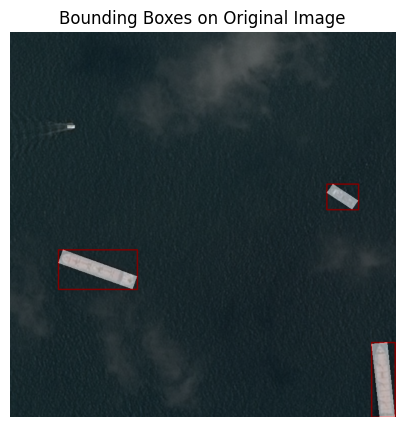

In [ ]:
# draw the bounding boxes around the ships in the predicted mask, overlay on the original image and original mask
def draw_bounding_boxes(mask, image_path, mask_path):
    """
    Draws bounding boxes around ships in the mask and overlays them on the original image.
    """
    # Load the original image
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)

    mask = np.array(Image.open(mask_path).convert("L"))

    # Find contours in the mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw bounding boxes
    for contour in contours:
        if cv2.contourArea(contour) < 100:  # Filter out small areas
            continue
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image_np, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Display the result
    plt.figure(figsize=(10, 5))
    plt.imshow(image_np)
    plt.imshow(mask, alpha=0.5, cmap='gray')  # Overlay the mask
    plt.title("Bounding Boxes on Original Image")
    plt.axis('off')
    plt.show()



# Example usage
draw_bounding_boxes(mask, "./airbus-ship-detection/train_v2/007b25c03.jpg", "./airbus-ship-detection/train_masks/007b25c03.png")

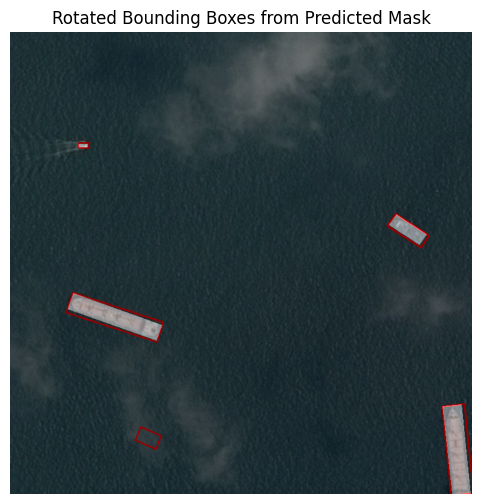

In [ ]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

def draw_bounding_boxes(predicted_mask, image_path, mask_path):
    """
    Draws rotated bounding boxes around ships in the predicted mask,
    and overlays them on the original RGB image with the ground truth mask.
    """
    # Load original image
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)

    # Load ground truth mask for optional overlay
    gt_mask = np.array(Image.open(mask_path).convert("L"))

    # Ensure predicted mask is a NumPy array (already passed as argument)
    if isinstance(predicted_mask, Image.Image):
        predicted_mask = np.array(predicted_mask.convert("L"))
    else:
        predicted_mask = predicted_mask.astype(np.uint8)

    # Find contours from the predicted mask
    contours, _ = cv2.findContours(predicted_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw rotated bounding boxes
    for contour in contours:
        if cv2.contourArea(contour) < 100:  # filter small artifacts
            continue
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.intp(box)
        cv2.drawContours(image_np, [box], 0, (255, 0, 0), 2)  # red rotated box

    # Display
    plt.figure(figsize=(6, 6))
    plt.imshow(image_np)
    plt.imshow(gt_mask, alpha=0.4, cmap='gray')  # ground truth mask (optional)
    plt.title("Rotated Bounding Boxes from Predicted Mask")
    plt.axis('off')
    plt.show()

# Let's say `predicted_mask` is the output of your model (e.g. binary 0/1 array)
draw_bounding_boxes(
    predicted_mask=mask,  # This is the model output (e.g. numpy array)
    image_path="./airbus-ship-detection/train_v2/007b25c03.jpg",
    mask_path="./airbus-ship-detection/train_masks/007b25c03.png"
)
